<a href="https://colab.research.google.com/github/pratik-tan10/Python/blob/main/Notebooks/ExplainableAI/Binary_Classification_Shapley_Values.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Contents
- [Obtain data](#obtain-data)
- [Build the model](#bulding)
- [Train the model](#train)
- [Predict using the trained model](#prediction)
- [Visualize output form intermediate layers](#intermediate)
- [Explain the model model outcome](#explaining)

**IMPORTANT NOTE:** This notebook is designed to run as a Colab. Running it on your local machine might result in some of the code blocks throwing errors.

<a name = "obtain-data"></a>
## Download and Inspect the Dataset

Download ["Dogs vs. Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data) available on Kaggle, which contains 25,000 images.

In [1]:
!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2023-06-08 20:04:14--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  18.0MB/s    in 4.6s    

2023-06-08 20:04:19 (14.1 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



### Unzip the data

In [2]:
import zipfile

# Unzip the archive using the with command
with zipfile.ZipFile('./cats_and_dogs_filtered.zip', 'r') as zip_ref:
  zip_ref.extractall()

### Setup path to training/validation data

In [4]:
import os

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')


### Display some of the exmaples

<Figure size 1600x1600 with 0 Axes>

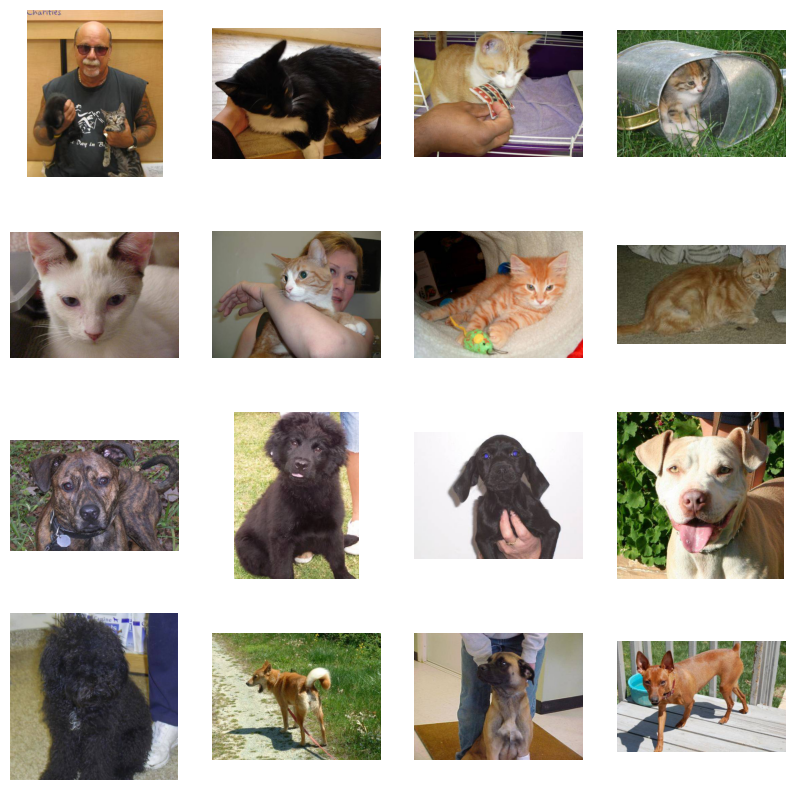

In [8]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images


# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
plt.figure(figsize = (10,10))
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


<a name = "building"></a>
## Building a Small Model from Ground-up

In [12]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(filters = 16, kernel_size  = (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(units = 512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(units = 1, activation='sigmoid')  
])

SyntaxError: ignored

Notice the `input_shape` which is `(150, 150, 3)` meaning that, it will take a rgb image of 150 rows and 150 columns.
also Notice the output layer where `units` is 1, as this is a binary classification problem.

Note that because you are facing a two-class classification problem, i.e. a *binary classification problem*, you will end the network with a [*sigmoid* activation](https://wikipedia.org/wiki/Sigmoid_function). The output of the network will be a single scalar between `0` and `1`, encoding the probability that the current image is class `1` (as opposed to class `0`).

You can review the architecture of the network with the `model.summary()` method: 

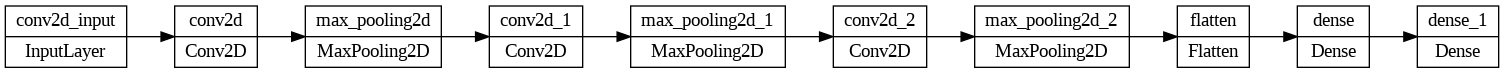

In [13]:
tf.keras.utils.plot_model(model, rankdir = "LR")

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

The `output_shape` column shows how the size of your feature map evolves in each successive layer. The convolution operation removes the outermost pixels from the original dimensions, and each pooling layer halves it.

Now set the loss to `binary_crossentropy` and use the `rmsprop` optimizer with a learning rate of `0.001`. Monitor `accuracy` during the training.

In [15]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

### Data Preprocessing

Use `keras.preprocessing.image.ImageDataGenerator` to convert image from `int` to `float32` using `rescale` parameter. Also  use `ImageDataGenerator`  to instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`.

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


<a name = "train"></a>
### Training
Let's train for 15 epochs and monitor loss and accuracy.


In [17]:
history = model.fit(
            train_generator,
            epochs=15,
            validation_data=validation_generator,
            verbose=2
            )

Epoch 1/15
100/100 - 23s - loss: 0.7560 - accuracy: 0.5285 - val_loss: 0.6779 - val_accuracy: 0.6080 - 23s/epoch - 225ms/step
Epoch 2/15
100/100 - 12s - loss: 0.6541 - accuracy: 0.6275 - val_loss: 0.6135 - val_accuracy: 0.6810 - 12s/epoch - 123ms/step
Epoch 3/15
100/100 - 11s - loss: 0.5947 - accuracy: 0.6885 - val_loss: 0.5578 - val_accuracy: 0.7180 - 11s/epoch - 106ms/step
Epoch 4/15
100/100 - 12s - loss: 0.5479 - accuracy: 0.7205 - val_loss: 0.6034 - val_accuracy: 0.6760 - 12s/epoch - 116ms/step
Epoch 5/15
100/100 - 13s - loss: 0.4947 - accuracy: 0.7540 - val_loss: 0.5455 - val_accuracy: 0.7410 - 13s/epoch - 127ms/step
Epoch 6/15
100/100 - 9s - loss: 0.4397 - accuracy: 0.7920 - val_loss: 0.5464 - val_accuracy: 0.7340 - 9s/epoch - 91ms/step
Epoch 7/15
100/100 - 9s - loss: 0.3679 - accuracy: 0.8365 - val_loss: 0.5548 - val_accuracy: 0.7240 - 9s/epoch - 93ms/step
Epoch 8/15
100/100 - 10s - loss: 0.3118 - accuracy: 0.8660 - val_loss: 0.6818 - val_accuracy: 0.7020 - 10s/epoch - 105ms/ste

<a name = "prediction"></a>
### Predict using the trained model

In [18]:
## NOTE: If you are using Safari and this cell throws an error,
## please skip this block and run the next one instead.

import numpy as np

from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded=files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path='/content/' + fn
  img=load_img(path, target_size=(150, 150))
  
  x=img_to_array(img)
  x /= 255
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes = model.predict(images, batch_size=10)
  
  print(classes[0])
  
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")
 

Saving cat1.jpg to cat1.jpg
1/1 [==============================] - 0s 184ms/step
[8.433689e-08]
cat1.jpg is a cat


<a name="intermediate"></a>
### Visualizing Intermediate Representations

1/1 [==============================] - 0s 106ms/step


<ipython-input-20-ef37dc9124ee>:48: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std ()


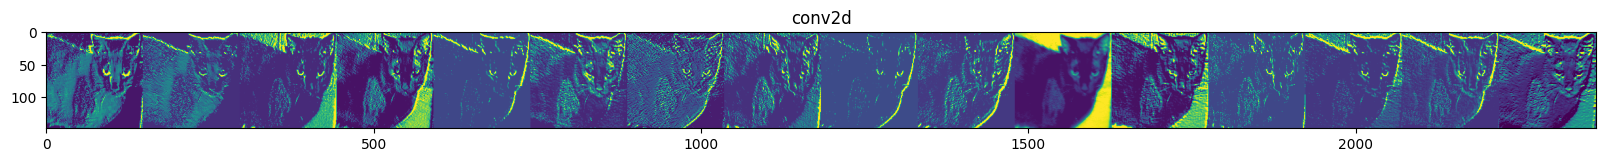

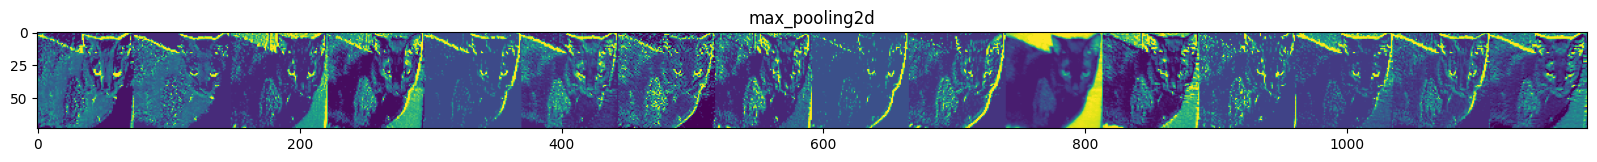

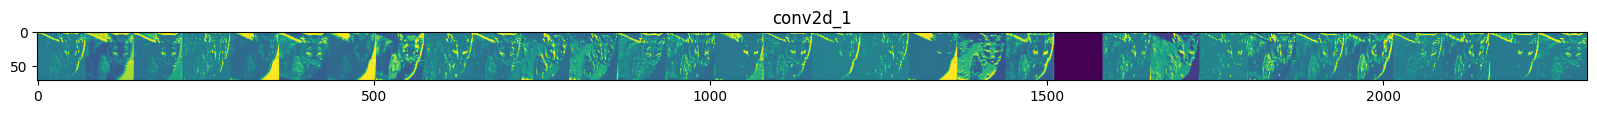

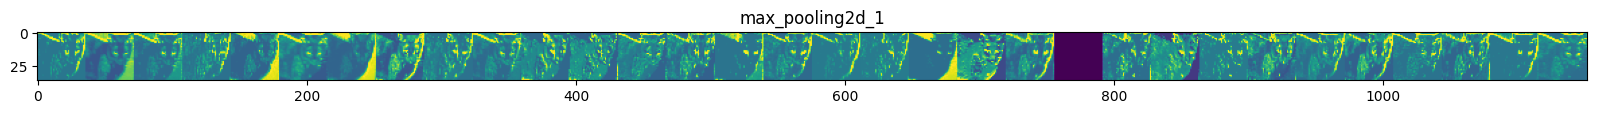

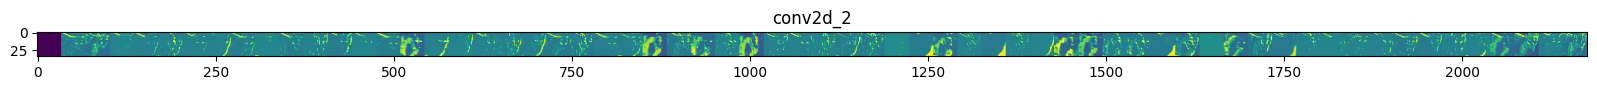

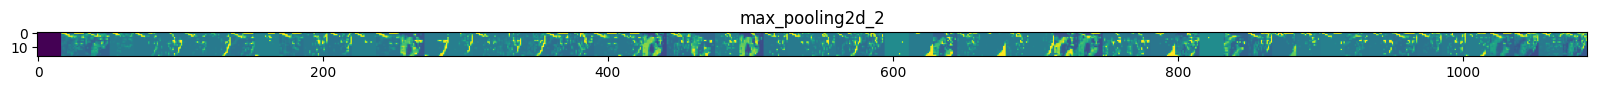

In [20]:
import numpy as np
import random
from tensorflow.keras.utils import img_to_array, load_img

# Define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model
successive_outputs = [layer.output for layer in model.layers]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Prepare a random input image from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]
img_path = random.choice(cat_img_files + dog_img_files)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Scale by 1/255
x /= 255.0

# Run the image through the network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so you can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Display the representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # Tile the images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

This shows what each convolution layer is learning.

<a name = "explaining"></a>
### Explaining using Shapley values

In [93]:
!pip -q install shap

In [22]:
import shap
from tensorflow import keras
import matplotlib.pyplot as plt

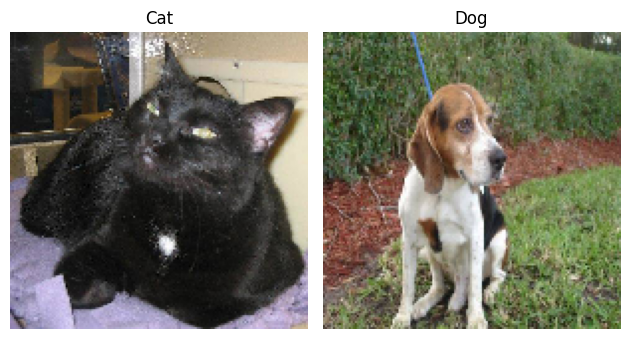

In [91]:
x_train, y_train = next(train_generator)
# Name each one of the classes
class_names = ['Cat', "Dog"]

# Save an example for each category in a dict
images_dict = dict()
for i, l in enumerate(y_train):
  if len(images_dict)==10:
    break
  if l not in images_dict.keys():
    images_dict[int(l)] = x_train[i]

# Function to plot images
def plot_categories(images):
  fig, axes = plt.subplots(1, 2)
  axes = axes.flatten()
  
  # Plot an image for every category
  for k,v in images.items():
    ax = axes[k]
    ax.imshow(v)
    ax.set_title(f"{class_names[k]}")
    ax.set_axis_off()

  plt.tight_layout()
  plt.show()


# Use the function to plot
plot_categories(images_dict)

In [78]:
background = next(validation_generator)[0]

# Use DeepExplainer to explain predictions of the model
e = shap.DeepExplainer(model, background)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [79]:
x_test, y_test = next(validation_generator)

# Name each one of the classes
class_names = ['Cat', "Dog"]

# Save an example for each category in a dict
x_test_dict = dict()
for i, l in enumerate(y_test):
  if len(images_dict)==10:
    break
  if l not in x_test_dict.keys():
    x_test_dict[l] = x_test[i]

# Convert to list preserving order of classes
x_test_each_class = [x_test_dict[i] for i in sorted(x_test_dict)]

# Convert to tensor
x_test_each_class = np.asarray(x_test_each_class)

# Print shape of tensor
print(f"x_test_each_class tensor has shape: {x_test_each_class.shape}")

x_test_each_class tensor has shape: (2, 150, 150, 3)


In [80]:
# Compute predictions
predictions = model.predict(x_test_each_class)

1/1 [==============================] - 0s 21ms/step


In [81]:
# Compute shap values using DeepExplainer instance
shap_values = e.shap_values(x_test_each_class)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


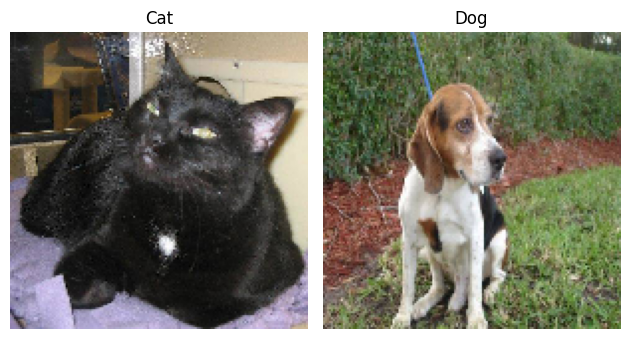

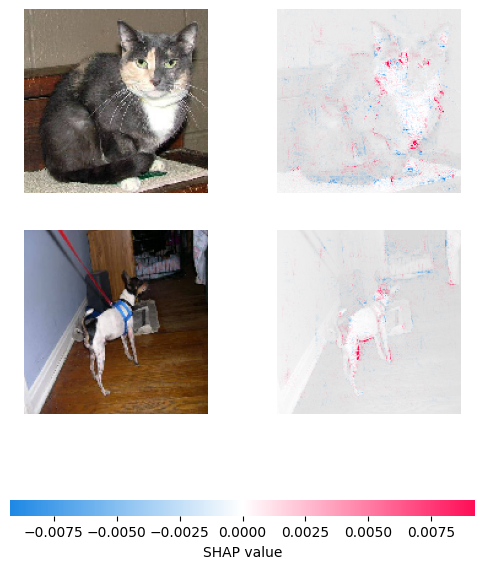

In [92]:
# Plot reference column
plot_categories(images_dict)

# Print an empty line to separate the two plots
print()

# Plot shap values
shap.image_plot(shap_values, x_test_each_class)

The pixels in red shade are contributing increase the value the output, meaning that they are responsible for saying the image belongs to `class 1`, which is dog, whereas the pixels in blue are contributing to decrease the value of the output and hence are saying the image has reasons to be classified as `class 0`, which is cat.

### Evaluating Accuracy and Loss for the Model

You will plot the training/validation accuracy and loss as collected during training:

Text(0.5, 1.0, 'Training and validation loss')

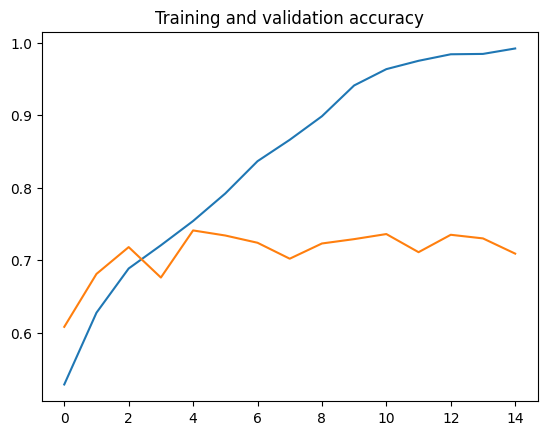

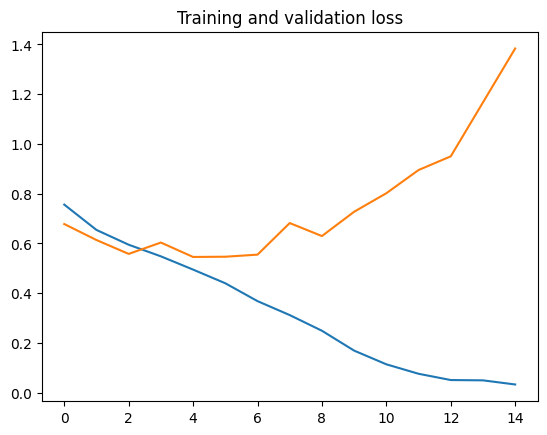

In [19]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )

As the training accuracy is really high but validation accuracy is low ~70%, the model is suffering from __Overfitting__. We will need to use more data or regularize or make the model a smaller one.

## Clean Up

Before running the next exercise, run the following cell to terminate the kernel and free memory resources:

In [ ]:
import os, signal

os.kill(os.getpid(), signal.SIGKILL)

In [ ]:
from keras.models import load_model  # TensorFlow is required for Keras to work
from PIL import Image, ImageOps  # Install pillow instead of PIL
import numpy as np

# Disable scientific notation for clarity
np.set_printoptions(suppress=True)

# Load the model
model = load_model("keras_Model.h5", compile=False)

# Load the labels
class_names = open("labels.txt", "r").readlines()

# Create the array of the right shape to feed into the keras model
# The 'length' or number of images you can put into the array is
# determined by the first position in the shape tuple, in this case 1
data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)

# Replace this with the path to your image
image = Image.open("<IMAGE_PATH>").convert("RGB")

# resizing the image to be at least 224x224 and then cropping from the center
size = (224, 224)
image = ImageOps.fit(image, size, Image.Resampling.LANCZOS)

# turn the image into a numpy array
image_array = np.asarray(image)

# Normalize the image
normalized_image_array = (image_array.astype(np.float32) / 127.5) - 1

# Load the image into the array
data[0] = normalized_image_array

# Predicts the model
prediction = model.predict(data)
index = np.argmax(prediction)
class_name = class_names[index]
confidence_score = prediction[0][index]

# Print prediction and confidence score
print("Class:", class_name[2:], end="")
print("Confidence Score:", confidence_score)